<a href="https://colab.research.google.com/github/matsunil/hdsi/blob/main/Embeddings_and_Foundation_Models_in_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Welcome to Lecture III of the HDSI GenAI Workshop


<img src="https://colab.research.google.com/drive/1CqjYQcNAo13N5YI593Lnq7GqbRwnShwB?usp=sharing" alt="drawing" width="400"/>


# **Embeddings and Foundation Models in Science**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 60 minutes.

Recommended Compute: Free T4 GPUs from Google Colab

## Oct 21, 2025  <br> Bret Nestor, Claudio Battiloro


Learning objectives:


1.   Cosine similarity: a comparison between two vectors
2.   Visual comparisons: PCA, t-SNE, UMAP
3.   Embedding your data: Everything is a vector!
4.   Retrieval Augmented Generation (RAG): Natural language queries over massive amounts of data.





### Primers
<div style="display:flex; gap:20px; flex-wrap:wrap">
  <div style="flex:1; min-width:320px">
    <p><b>t‑SNE intuitions (StatQuest)</b></p>
    <iframe width="100%" height="215" src="https://www.youtube.com/embed/NEaUSP4YerM" title="t-SNE explained" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>
    <a href="https://www.youtube.com/embed/NEaUSP4YerM">https://www.youtube.com/embed/NEaUSP4YerM</a>
  </div>
  <div style="flex:1; min-width:320px">
    <p><b>UMAP overview (PyData)</b></p>
    <iframe width="100%" height="215" src="https://www.youtube.com/embed/wP8uS7AgB4o" title="UMAP overview" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>
  </div>
  <a href="https://youtu.be/YPJQydzTLwQ?si=wOJuE5wL2Rj5G_8x">https://youtu.be/YPJQydzTLwQ?si=wOJuE5wL2Rj5G_8x</a>
</div>


## 0) Setup

We’ll use:
- **Text**: MiniLM embeddings (SentenceTransformers).
- **Search**: Cosine Similarity, UMAP/t‑SNE.
- **Molecules**: **RDKit** for fingerprints, **ChemBERTa** (HF) for SMILES embeddings.
- **Qwen3-0.6B** as an LLM

> All components are free to run on Colab. GPU helps but is optional.


In [ ]:

# %%capture
# # Core libraries
!pip -q install sentence-transformers==3.0.1 codecarbon \
                 umap-learn==0.5.6 plotly==5.23.0 \
                 transformers>=4.47.0 accelerate==0.34.2 bitsandbytes\
                 datasets==2.21.0 scikit-learn==1.5.1 \
                 rdkit langchain_huggingface langchain_community
# Torch/torchvision safety check (Colab usually has them)
import sys, subprocess
try:
    import torch, torchvision
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                           "torch", "torchvision", "torchaudio",
                           "--index-url", "https://download.pytorch.org/whl/cpu"])


In [ ]:

# Imports, seeds, device
import os, math, json, random, pathlib, re, itertools
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch:", torch.__version__)
print("Device:", device)


PyTorch: 2.8.0+cu126
Device: cuda




---



## 1) Primer: geometry of meaning


We want

<!-- \(f:\mathcal{X}\!\to\!\mathbb{R}^d\) -->


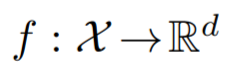


such that **semantic** and **geometric** neighborhoods align.  
Cosine similarity:

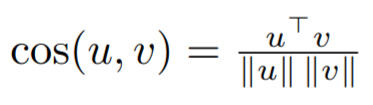


<!-- \(\cos(u,v)=\frac{u^\top v}{\lVert u\rVert\,\lVert v\rVert}\). -->



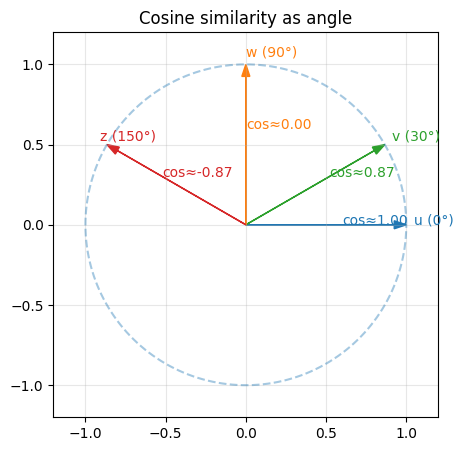

In [ ]:

# Cosine sketch (line-by-line)
import numpy as np, matplotlib.pyplot as plt
vectors = [
    ("u (0°)", np.array([1.0, 0.0])),
    ("v (30°)", np.array([np.cos(np.pi/6), np.sin(np.pi/6)])),
    ("w (90°)", np.array([0.0, 1.0])),
    ("z (150°)", np.array([np.cos(5*np.pi/6), np.sin(5*np.pi/6)])),
]
def draw_vec(ax, vec, label, color="black"):
    ax.arrow(0,0,vec[0],vec[1], head_width=0.05, length_includes_head=True, ec=color, fc=color)
    ax.text(vec[0]*1.05, vec[1]*1.05, label, color=color)
fig, ax = plt.subplots(figsize=(5,5))
theta = np.linspace(0, 2*np.pi, 400)
ax.plot(np.cos(theta), np.sin(theta), linestyle="--", alpha=0.4)
colors = ["tab:blue","tab:green","tab:orange","tab:red"]
u = vectors[0][1]
for (label, vec), c in zip(vectors, colors):
    draw_vec(ax, vec, label, color=c)
    cos_sim = np.dot(u, vec)/ (np.linalg.norm(u)*np.linalg.norm(vec))
    ax.text(vec[0]*0.6, vec[1]*0.6, f"cos≈{cos_sim:.2f}", color=c)
ax.set_aspect("equal"); ax.set_xlim(-1.2,1.2); ax.set_ylim(-1.2,1.2)
ax.set_title("Cosine similarity as angle"); ax.grid(True, alpha=0.3); plt.show()


# Everything is a Vector


**TLDR;** If you can store the information digitally, you can embed it using a machine learning model.

Lets look at a few examples for how we can represent information as *embedding vectors*.


### Images:
Digital images are represented as 3 dimensional matrices. The matrices have the dimensions `[height, width, 3]`. Where the 3 channels usually represent the relative "red", "green", and "blue" colour intensity calibrated to the human eye. We can standardize the input to machine learning models by reshaping images to a conisistent size (like 224x224x3).


### Audio:
Audio is transmitted as sound pressure waves through the air. Digitised audio represents this audio amplitude and regularly sampled intervals. For human speech, this is most often sampled 16000 times per second. Compared to other data forms there is much more data. However, we can compress this using convolutional neural networks.

### Text:
On our computers, our letters are represented as ASCII characters. Each letter is a represented as 7 bits (7-bits = 2^7 = 128). We could represent each letter as a number between 0 and 128. The sentence "This is the text" is a numerical vector `[84,104,105,115,32,105,115,32,116,104,101,32,116,101,120,116]`. Modern language models enumerate words, or pieces of words:

```python
>>> from transformers import AutoTokenizer
>>> tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased",)
>>> tokenizer("This is the text")
{'input_ids': [101, 2023, 2003, 1996, 3793, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
>>> tokenizer.decode(tokenizer("This is the text").input_ids)
'[CLS] this is the text [SEP]'
```

It is the objective of the embedding model to learn a mapping (or embedding) from the "input_id" to a meaningful object even if the input_ids are randomly assigned to each word. This embedding matrix is a lookup table. In other words, you will have an embedding matrix with the length of your vocabulary by the width of your embedding vector dimension. We can pad these to a uniform maximum length so that we can always have a consistent size for the model. This maximum length is called the *context length*.

```python
...
>>> tokenizer("This is the text", max_length=32, padding="max_length")
{'input_ids': [101, 2023, 2003, 1996, 3793, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
>>> tokenizer.decode(tokenizer("This is the text", max_length=32, padding="max_length").input_ids)
'[CLS] this is the text [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'
```

### Asynchronous time-series:
Synchronous data can be represented using techniques similar to audio and text. However, asynchronous data might need to be additional formatting to be embedded









---


## 2) MiniLM embeddings + t‑SNE


### t-SNE intuition

The t- Distributed Stochastic Neighbor Embedding is a data visualization technique


t‑SNE preserves local neighborhoods by minimizing a KL divergence between high dimensional and low dimensional neighbor probabilities. In essence, it is PCA, but for high dimensional data.

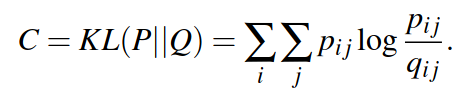

Where "p" represents the conditional probability of a point to be near another on a high dimensional manifold, and "q" represents the conditional probability of a point to be near itself on a low-dimensional manifold. A student-t distribution is chosen for its heavy tails


Quiz: Can you use add a new sample to an already fitted t-SNE ?
<!--
No, since the probability distributions are computed by the normalizing by all distances between points. -->

Tip: In practice, PCA is used to project high dimensional vectors down to about 50 dimensions, then t-SNE is used on these 50-dimensional vectors to further reduce the data down to 2 dimensions for visualization. This leads to a linear reduction in time (a t-SNE on a set of points with 1000 dimensions will be approximately 20 times slower than a PCA on a set of points that were compressed using PCA to 50 dimensions).

Use it for intuition; tune **perplexity**.


Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.

In [ ]:

import torch
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

import matplotlib.pyplot as plt



# sentence-transformers/all-MiniLM-L6-v2 is governed under an apache-2.0 license
model_st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
print("Model loaded")
corpus = [
    ("astronomy", "We analyze exoplanet transit curves using Gaussian processes."),
    ("astronomy", "Spectral lines indicate molecular absorption in exoplanet atmospheres."),
    ("astronomy", "Stellar variability complicates radial velocity measurements."),
    ("bio", "Single-cell RNA-seq reveals heterogeneous cell populations."),
    ("bio", "Gene regulatory networks can be inferred with sparse models."),
    ("bio", "Protein-ligand docking evaluates binding affinities in silico."),
    ("climate", "Downscaled climate projections inform regional adaptation strategies."),
    ("climate", "Extreme heat events correlate with excess mortality in urban areas."),
    ("climate", "Satellite data improves drought monitoring in agriculture."),
    ("physics", "Variational Monte Carlo approximates ground state wavefunctions."),
    ("physics", "We derive bounds for error propagation in quantum circuits."),
    ("physics", "Finite element solvers simulate elastic deformations in materials."),
]
# zip apart the labels and the correpsonding texts
labels, texts = zip(*corpus)

# create number indices for the labels
label2id = {c:i for i,c in enumerate(sorted(set(labels)))}
y = np.array([label2id[l] for l in labels])

# use sentence_transformer to embed the text using the model
X_emb = model_st.encode(list(texts), convert_to_numpy=True, device=device, normalize_embeddings=True)

print("The embedding features have the shape of:", X_emb.shape)

# use plotly for the hover feature
colours = [ '#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000','#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000']

X_2d = TSNE(n_components=2, perplexity=5, random_state=SEED, init='pca', learning_rate='auto').fit_transform(X_emb)
fig = px.scatter(x=X_2d[:,0],
                 y=X_2d[:,1],
                 color=[labels[i] for i in range(len(labels))],
                 color_discrete_sequence=colours,
                 hover_data={"text": list(texts)},
                 title="t-SNE of Text Embeddings (MiniLM)",
                 template="simple_white")

fig.update_traces(marker={'size': 15})
fig.update_xaxes(title_font=dict(size=18, family='Ariel', color='black'))
fig.update_yaxes(title_font=dict(size=18, family='Ariel', color='black'))
fig.show()





Model loaded
The embedding features have the shape of: (12, 384)




---


## 3) Swiss‑roll + UMAP vs t‑SNE  (with stability metrics)

UMAP preserves **local fuzzy topology** via a k‑NN graph + cross‑entropy; compare to t‑SNE (KL objective). We’ll visualize unrolling and compute **trustworthiness** + **neighborhood‑overlap (Jaccard)** vs original space and across hyperparameters.


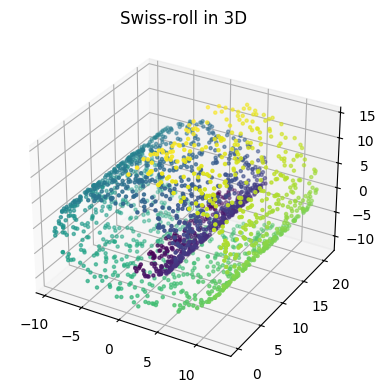

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



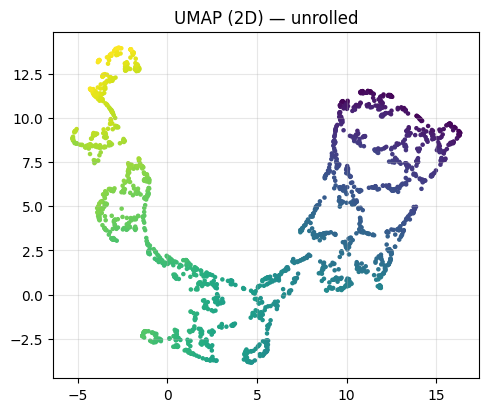

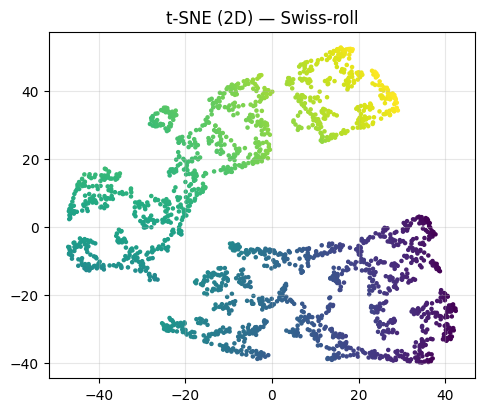

umap:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



tsne:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

from sklearn.datasets import make_swiss_roll, make_blobs
import umap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

# Generate Swiss-roll for geometry intuition
n_samples = 2000
X3d, t = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=SEED)

# 3D view
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X3d[:,0], X3d[:,1], X3d[:,2], c=t, s=5)
ax.set_title("Swiss-roll in 3D"); plt.show()

# UMAP 2D
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=SEED).fit_transform(X3d)
plt.figure(figsize=(5.5,4.5)); plt.scatter(umap_2d[:,0], umap_2d[:,1], c=t, s=5)
plt.title("UMAP (2D) — unrolled"); plt.grid(True, alpha=0.3); plt.show()

# t-SNE 2D
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=SEED, init='pca', learning_rate='auto').fit_transform(X3d)
plt.figure(figsize=(5.5,4.5)); plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c=t, s=5)
plt.title("t-SNE (2D) — Swiss-roll"); plt.grid(True, alpha=0.3); plt.show()

# Stability metrics helpers
def knn_indices(X, k=10, metric="euclidean"):
    D = pairwise_distances(X, metric=metric)
    np.fill_diagonal(D, np.inf)
    return np.argsort(D, axis=1)[:, :k]

def mean_jaccard(idxA, idxB):
    total = 0.0
    for a, b in zip(idxA, idxB):
        A, B = set(a), set(b)
        inter, union = len(A & B), len(A | B)
        total += (inter/union) if union else 1.0
    return total / idxA.shape[0]

# Compare across params
k = 10
umap_neighbors = [5, 10, 15, 30, 50]
tsne_perplexities = [5, 10, 20, 30, 50]

knn_orig = knn_indices(X3d, k=k)

trust_u, jac_u, trust_t, jac_t = [], [], [], []
for nn in tqdm(umap_neighbors, desc="umap"):
    Y = umap.UMAP(n_neighbors=nn, min_dist=0.1, metric='euclidean', random_state=SEED).fit_transform(X3d)
    trust_u.append(trustworthiness(X3d, Y, n_neighbors=k))
    jac_u.append(mean_jaccard(knn_orig, knn_indices(Y, k=k)))
for perp in tqdm(tsne_perplexities, desc="tsne"):
    Y = TSNE(n_components=2, perplexity=perp, random_state=SEED, init='pca', learning_rate='auto').fit_transform(X3d)
    trust_t.append(trustworthiness(X3d, Y, n_neighbors=k))
    jac_t.append(mean_jaccard(knn_orig, knn_indices(Y, k=k)))

# Plot
plt.figure(figsize=(6,4))
plt.plot(umap_neighbors, trust_u, marker="o", label="UMAP trust");
plt.plot(tsne_perplexities, trust_t, marker="o", label="t-SNE trust");
plt.xlabel("neighbors / perplexity"); plt.ylabel("Trustworthiness (k=10)"); plt.title("Stability: trustworthiness"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()
plt.ylabel([0, 1])

plt.figure(figsize=(6,4))
plt.plot(umap_neighbors, jac_u, marker="o", label="UMAP Jaccard");
plt.plot(tsne_perplexities, jac_t, marker="o", label="t-SNE Jaccard");
plt.xlabel("neighbors / perplexity"); plt.ylabel("Mean Jaccard (k-NN vs orig)"); plt.title("Stability: neighborhood overlap"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()
plt.ylabel([0,1])




---


### 4) Diminishing returns vs training size

Embeddings preserve semantic information when the embedding model is suitable! We can do all sorts of things with these, from 2-d visualisation, similarity comparisons, or even train simpler machine learning models on top of these semantically meaningful features.


Compare term-frequency inverse document frequency (TF-InvDF) + LR, MiniLM (frozen) + LR on a **20 Newsgroups** subset. Expect embeddings to be **data‑efficient** at small (n).


embedding samples using cuda
[0 1 3 2 1]


Training model:   0%|          | 0/7 [00:00<?, ?it/s]

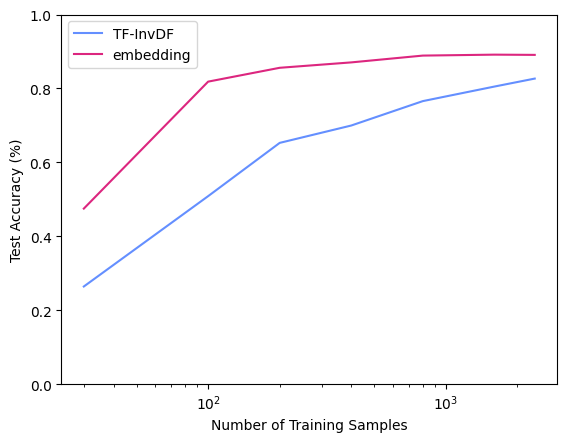

In [ ]:

from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from tqdm.notebook import tqdm

cats = ['sci.space','sci.med','comp.graphics','rec.autos']
train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
test  = fetch_20newsgroups(subset='test',  categories=cats, remove=('headers','footers','quotes'))

sizes = [30, 100, 200, 400, 800, 1600, len(train.data)]

def run_pipeline_text(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)
    return accuracy_score(y_test, clf.predict(X_test))

def run_tf_pipeline_text(X_train, y_train, X_test, y_test):
    TFinvDF = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
    X_train_tfinvdf = TFinvDF.fit_transform(X_train)
    X_test_tfinvdf = TFinvDF.transform(X_test)
    return run_pipeline_text(X_train_tfinvdf, y_train,  X_test_tfinvdf, y_test)

print(f"embedding samples using {device}")
embed_train = model_st.encode(train.data, convert_to_numpy=True, normalize_embeddings=True, device=device)
embed_test = model_st.encode(test.data,  convert_to_numpy=True, normalize_embeddings=True, device=device)

print(train.target[:5])


results = {"size": [], "tfinvdf_acc": [], "embed_acc": []}
for n in tqdm(sizes, desc="Training model"):
    sub = np.arange(min(n, len(train.data)))
    results["size"].append(len(sub))
    results["tfinvdf_acc"].append(run_tf_pipeline_text(train.data[:max(sub+1)], train.target[sub], test.data, test.target))
    results["embed_acc"].append(run_pipeline_text(embed_train[sub], train.target[sub], embed_test, test.target))

df_curve = pd.DataFrame(results)
# display(df_curve)


colours = [ '#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000','#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000']

fig = plt.figure()
plt.plot(df_curve['size'],df_curve['tfinvdf_acc'], label="TF-InvDF", c='#648fff')
plt.plot(df_curve["size"], df_curve["embed_acc"], label="embedding", c='#dc267f')
plt.legend()
plt.ylabel("Test Accuracy (%)")
plt.ylim([0,1])
plt.xlabel("Number of Training Samples")
plt.xscale("log")

plt.show()


## A good rule of thumb:
* No labelled data: stick to zero-shot generalization.
* A bit of labelled data: use embeddings.
* A log of labelled data: fine-tune a model.
* All of the labelled data: train your own model from scratch



---


## 6) Molecular embeddings (RDKit + ChemBERTa)

A well trained model can represent digital data as a semantic vector. The more expressive the model, the better the vector (or embedding). In a famous exercise, you can algebraicly operate on concepts as such:

`embedding("man") + embedding("king") - embedding("woman") = embedding("queen")`








We can encode molecules using the *SMILES* notation (Simplified Molecular Input Line Entry System). We can use an embedding model trained on **SMILES** to compare molecules, cluster chemical space, and do property prediction.

**Two approaches:**
1. **RDKit Morgan fingerprints** (circular fingerprints) → binary vectors (e.g., 2048 bits). (CC BY SA)
2. **ChemBERTa** (HF) → contextual embeddings from SMILES; we pool the hidden states. (MIT License)

We’ll build both, visualize with UMAP, and do nearest‑neighbor search. Bonus: enter your own SMILES to find similar molecules.


In [ ]:
# build a custom search database
from typing import Union, Tuple
import numpy as np
import torch
import torch.nn.functional as F

class CustomCosineSearchIndex():
    def __init__(self, embedding_dimension: int, index_type: str = "flat_ip"):
        """
        A cosine similarity search with usage similar to FAISS.

        index_type: "flat_ip" for inner product (cosine similarity with normalized vectors)
        embedding_dimension: dimension of the embeddings
        """

        if index_type not in ["flat_ip"]:
            raise NotImplementedError(f"Index type {index_type} not implemented.")

        self.index_type = index_type
        self.embedding_dimension = embedding_dimension
        # self.normalize_embeddings = normalize_embeddings

    def add_embeddings(self, embeddings: Union[np.ndarray, torch.Tensor]) -> None:
        """
        Add embeddings to the index.
        """
        if isinstance(embeddings, np.ndarray):
            embeddings = torch.tensor(embeddings).float()
        else:
            assert isinstance(embeddings, torch.Tensor), "Embeddings should be a numpy array or torch tensor"

        assert embeddings.dim() == 2, "Embeddings should be a 2D tensor in the shape of (num_samples, embedding_dimension)"
        assert embeddings.shape[1] == self.embedding_dimension, "Embeddings shape mismatch"

        # calculate the norm v=v.max(∥v∥p​,ϵ)
        self.normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

    def search(self, query_embedding: Union[np.ndarray, torch.Tensor], top_k: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Input:
            query_embedding: a 2D numpy array or torch tensor of shape (1, embedding_dimension)
            top_k: number of top results to return
        Output:
            distances: a 1D numpy array of shape (top_k,) with the similarity scores
            indices: a 1D numpy array of shape (top_k,) with the indices of the top_k most similar embeddings
        """
        print(type(query_embedding))
        # normalize the query embedding
        if isinstance(query_embedding, np.ndarray):
            query_embedding = torch.tensor(query_embedding).float()
        else:
            assert isinstance(query_embedding, torch.Tensor), "Query embedding should be a numpy array or torch tensor"

        assert query_embedding.dim() == 2, "Query embedding should be a 2D tensor in the shape of (1, embedding_dimension)"
        assert query_embedding.shape[1] == self.embedding_dimension, "Query embedding shape mismatch"

        normalized_query = F.normalize(query_embedding, p=2, dim=1)

        distances = F.cosine_similarity(self.normalized_embeddings, normalized_query, dim=1).cpu().data.numpy()
        top_k_indices = np.argsort(-distances)[:top_k]
        top_k_distances = distances[top_k_indices]
        return top_k_distances, top_k_indices

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 08587298-7bf4-416d-849f-a5373587b583)')' thrown while requesting HEAD https://huggingface.co/DeepChem/ChemBERTa-77M-MLM/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b1a4fb98-ed86-432e-a6f0-97cd72940526)')' thrown while requesting HEAD https://huggingface.co/DeepChem/ChemBERTa-77M-MLM/resolve/main/special_tokens_map.json
Retrying in 1s [Retry 1/5].


special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16:51:06] DEPRECATION WARNING: please use MorganGenerator
[16

Computing embeddings for morgan_FP
Computing embeddings for ChemBERTa


model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

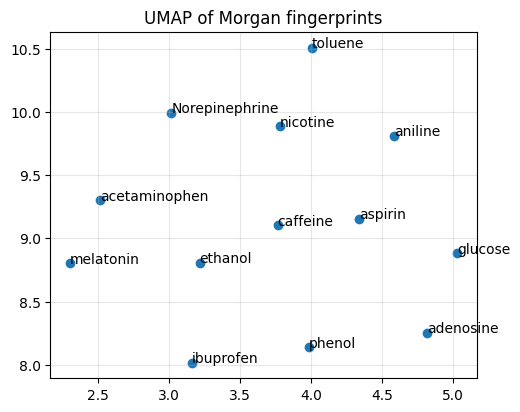

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



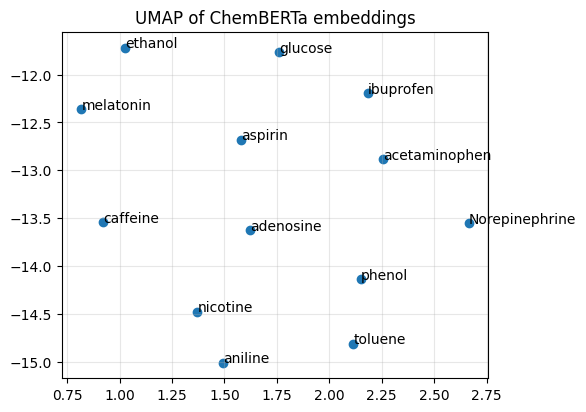

Epinephrine
CNC[C@@H](C1=CC(=C(C=C1)O)O)O
<class 'numpy.ndarray'>
FP ('Norepinephrine', 'C1=CC(=C(C=C1[C@H](CN)O)O)O') similarity: [0.7360748]
<class 'numpy.ndarray'>
chemBERTa ('Norepinephrine', 'C1=CC(=C(C=C1[C@H](CN)O)O)O') similarity: [0.93848926]


[16:51:08] DEPRECATION WARNING: please use MorganGenerator


In [ ]:

# RDKit Morgan fingerprints + ChemBERTa pooled embeddings + UMAP demo
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import umap
from transformers import AutoTokenizer, AutoModel

# Small demo set: (name, SMILES). Feel free to extend with your favorites!
mols = [
    ("aspirin", "CC(=O)OC1=CC=CC=C1C(=O)O"),
    ("acetaminophen", "CC(=O)NC1=CC=C(C=C1)O"),
    ("ibuprofen", "CC(C)C(=O)C1=CC=C(C=C1)C(C)C(=O)O"),
    ("caffeine", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"),
    ("adenosine", "C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O)N"),
    ("melatonin", "CC(=O)NCCc1c[nH]c2ccc(OC)cc12"),
    ("nicotine", "CN1CCC[C@H]1C2=CN=CC=C2"),
    ("glucose", "OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)1"),
    ("steviol","O=C(O)[C@]4([C@H]3CC[C@@]21C[C@](O)(\C(=C)C1)CC[C@H]2[C@]3(C)CCC4)C"),
    ("sorbitol", "OC([C@H](O)[C@@H](O)[C@H](O)CO)CO")
    ("ethanol", "CCO"),
    ("toluene", "CC1=CC=CC=C1"),
    ("phenol", "C1=CC=C(C=C1)O"),
    ("aniline", "C1=CC=C(C=C1)N"),
    ("norepinephrine", "C1=CC(=C(C=C1[C@H](CN)O)O)O"),
    ("seratonin", "C1=CC2=C(C=C1O)C(=CN2)CCN"),
    ("dopamine", "NCCc1cc(O)c(O)cc1"),
    ("morphine", "CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5"),
    ("PFOA","FC(F)(C(F)(F)C(=O)O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F")
]

# --- Helper: RDKit Morgan fingerprint (radius=2, nBits=2048) ---
def morgan_fp(smiles, nbits=2048, radius=2):
    m = Chem.MolFromSmiles(smiles)
    if m is None: return None
    fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)
    arr = np.zeros((nbits,), dtype=np.float32)
    Draw.rdMolDraw2D.PrepareMolForDrawing(m)  # ensure sanitization for drawing if needed
    # Convert RDKit ExplicitBitVect to numpy array of 0/1
    for i in range(nbits):
        arr[i] = 1.0 if fp.GetBit(i) else 0.0
    return arr

# --- Helper: ChemBERTa pooled embedding ---
chemberta_name = "DeepChem/ChemBERTa-77M-MLM"
tok_c = AutoTokenizer.from_pretrained(chemberta_name)
mdl_c = AutoModel.from_pretrained(chemberta_name).to(device).eval()

def chemberta_embed(smiles):
    # Tokenize SMILES; get hidden states; mean-pool (simple & effective)
    enc = tok_c(smiles, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        out = mdl_c(**enc).last_hidden_state  # [B, T, H]
        emb = out.mean(dim=1)                 # [B, H] pooled
        emb = torch.nn.functional.normalize(emb, dim=-1)  # normalize for cosine
    return emb.detach().cpu().numpy().astype("float32")

# names = [n for n,_ in mols]
# smiles_list = [s for _,s in mols]
names, smiles_list = zip(*mols)

# Compute embeddings
print("Computing embeddings for morgan_FP")
fps = [morgan_fp(s) for s in smiles_list]
fps = [f for f in fps if f is not None]
fps = np.stack(fps, axis=0)

print("Computing embeddings for ChemBERTa")
chem_emb = chemberta_embed(smiles_list)  # pooled embeddings

# UMAP visualization for both spaces (side-by-side in two cells for simplicity)
u_fps = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=SEED).fit_transform(fps)
plt.figure(figsize=(5.5,4.5))
plt.scatter(u_fps[:,0], u_fps[:,1])
for i, label in enumerate(names):
    plt.text(u_fps[i,0], u_fps[i,1], label)
plt.title("UMAP of Morgan fingerprints"); plt.grid(True, alpha=0.3); plt.show()

u_chem = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=SEED).fit_transform(chem_emb)
plt.figure(figsize=(5.5,4.5))
plt.scatter(u_chem[:,0], u_chem[:,1])
for i, label in enumerate(names):
    plt.text(u_chem[i,0], u_chem[i,1], label)
plt.title("UMAP of ChemBERTa embeddings"); plt.grid(True, alpha=0.3); plt.show()



index_fps = CustomCosineSearchIndex(fps.shape[1])
index_fps.add_embeddings(fps.astype(float))

index_chem = CustomCosineSearchIndex(chem_emb.shape[1])
index_chem.add_embeddings(chem_emb.astype(float))

# get an query of the fingerprint model
# new molecule
print("Epinephrine")
print("CNC[C@@H](C1=CC(=C(C=C1)O)O)O")
fpq = morgan_fp("CNC[C@@H](C1=CC(=C(C=C1)O)O)O")
qchem = chemberta_embed("CNC[C@@H](C1=CC(=C(C=C1)O)O)O")

top_fp , top_index_fp = index_fps.search(query_embedding=fpq.reshape(1, -1), top_k=1)
print("FP", mols[top_index_fp[0]], "similarity:", top_fp)

top_chem , top_index_chem = index_chem.search(query_embedding=qchem.reshape(1, -1), top_k=1)
print("chemBERTa", mols[top_index_chem[0]], "similarity:", top_chem)




## 4) CLIP: zero‑shot image–text retrieval

CLIP aligns images and text in one space via a contrastive objective. Prompts like “a photo of a cat” retrieve cats—no task‑specific training.


Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/208 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/161 [00:00<?, ?it/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9d63bfe4-e323-44de-bf62-faa56c6897a4)')' thrown while requesting GET https://huggingface.co/datasets/EPFL-ECEO/CanadaFireSat/resolve/b4ebb9752245dd0388e469bc0d9c4572b3375e7d/New%20Brunswick/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].


'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0b1c7d46-d4ea-4c20-9792-f2c17b5c34ff)')' thrown while requesting GET https://huggingface.co/datasets/EPFL-ECEO/CanadaFireSat/resolve/b4ebb9752245dd0388e469bc0d9c4572b3375e7d/New%20Brunswick/test-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 73430b36-2e68-4716-9f41-27d761ab0ed8)')' thrown while requesting GET https://huggingface.co/datasets/EPFL-ECEO/CanadaFireSat/resolve/b4ebb9752245dd0388e469bc0d9c4572b3375e7d/New%20Brunswick/test-00000-of-00001.parquet
Retrying in 2s [Retry 2/5].


Generating train split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating test_hard split:   0%|          | 0/21 [00:00<?, ? examples/s]

  0%|          | 0/13 [00:00<?, ?it/s]

['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi']
['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi']
['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi']
['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tensor([0.2074, 0.1430, 0.1613, 0.1564, 0.1622, 0.1331, 0.1131, 0.1684, 0.2059,
        0.1661, 0.1084, 0.1424, 0.1542])


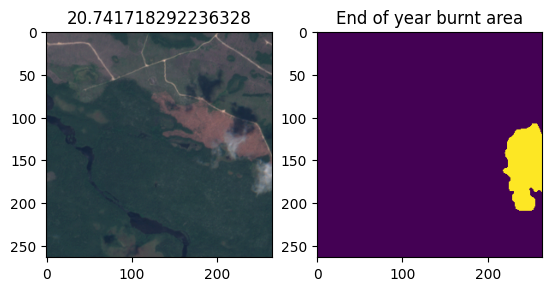

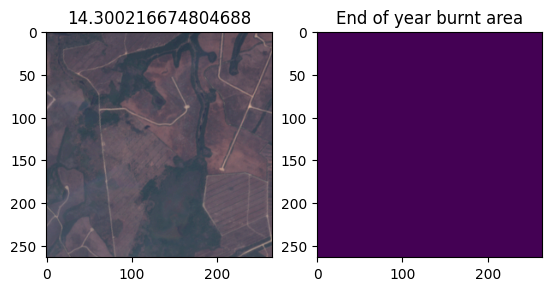

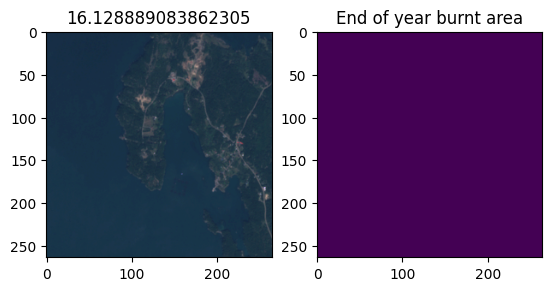

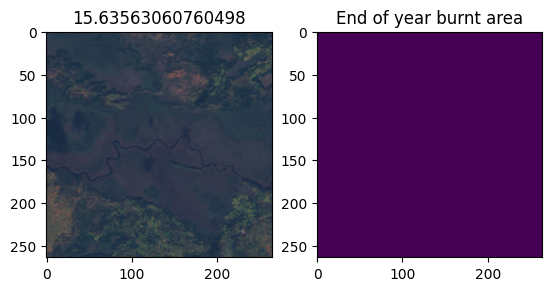

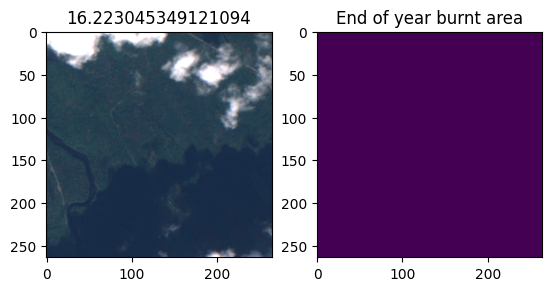

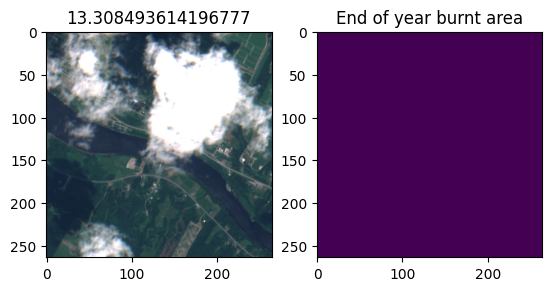

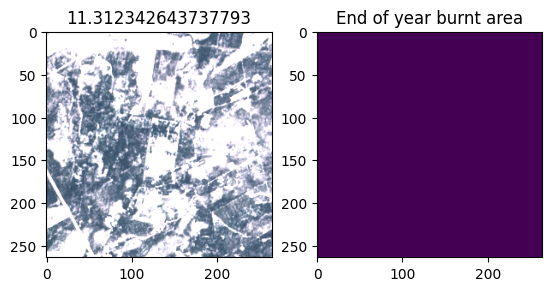

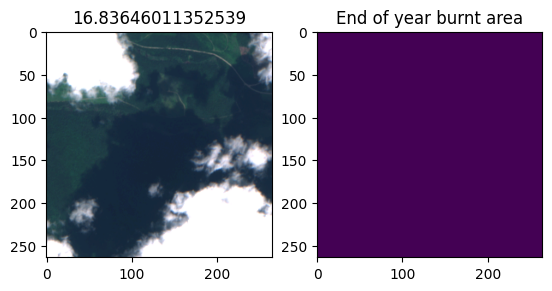

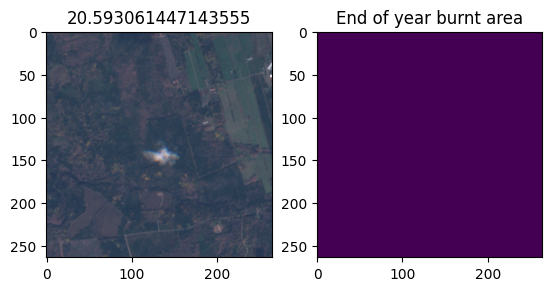

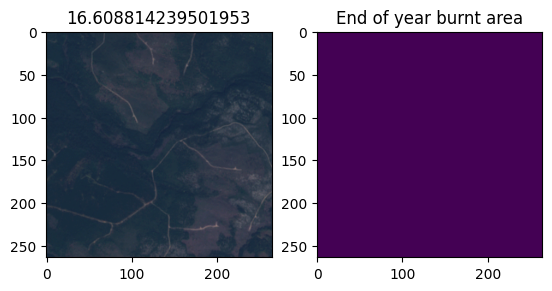

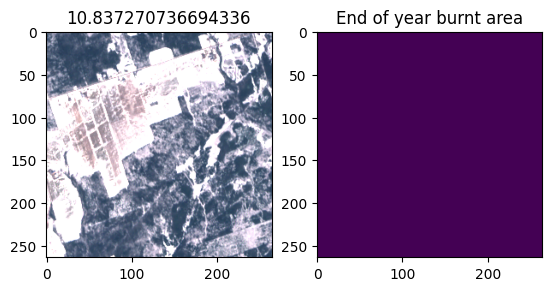

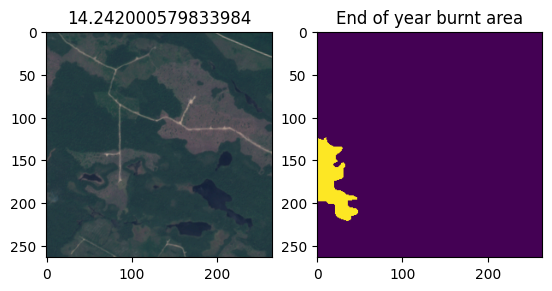

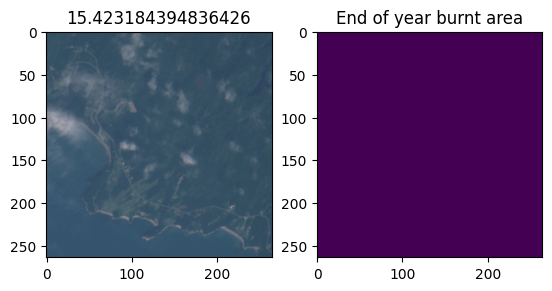

[20.741718292236328, 20.593061447143555, 16.83646011352539]


In [ ]:
"""
Procedure:
1) Download some data
2) Embed the sample images using CLIP
3) Embed a query using CLIP
4) Find similar data

dataset citation:
@article{porta2025canadafiresat,
  title={CanadaFireSat: Toward high-resolution wildfire forecasting with multiple modalities},
  author={Porta, Hugo and Dalsasso, Emanuele and McCarty, Jessica L and Tuia, Devis},
  journal={arXiv preprint arXiv:2506.08690},
  year={2025}
}

"""

from PIL import Image
import requests

# ML
from transformers import AutoProcessor, CLIPModel
from codecarbon import EmissionsTracker
import torch.nn.functional as F
import torch


# Data
from datasets import load_dataset
from skimage.exposure import rescale_intensity

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# set numy seed
np.random.seed(0)

# del images
try:
  images # this will fail if it is not yet defined
  labels
except:
  # load a small dataset
  dataset = load_dataset("EPFL-ECEO/CanadaFireSat", "New Brunswick", split="train") # ask questions about sattelite images

  # set random seed shuffle
  dataset = dataset.shuffle(seed=42).select(range(13))
  images = []
  labels = []
  for i, data_object in tqdm(enumerate(iter(dataset)), total=len(dataset)):
    # if i==25: break
    print(list(data_object.keys()))
    image = data_object["10x"] # sequence of images shape batch, 4, 224, 224)
    random_index = np.random.randint(len(image))
    random_index=-2 # the one before the burnt image

    rgb_image = np.asarray(image)[random_index].transpose(1,2,0)
    rgb_image = rgb_image[:, :, :3] # RGB is b4, b3, b2

    rgb_image = rescale_intensity(rgb_image, in_range=(0, 255 * 0.3), out_range=(0, 255)).astype(np.uint8)

    images.append(rgb_image)

    label_img = np.asarray(data_object["labels"]).astype(int)
    labels.append(label_img)


processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14", use_fast=False)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")


inputs = processor(text=["Forest fire smoke"], images=images, return_tensors="pt", )


with EmissionsTracker() as tracker:
  with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image # this is the image-text similarity score

# print(outputs.image_embeds)
# print(outputs.text_embeds)

# compute the cosine similarity
cos_sim = F.normalize(outputs.image_embeds, dim=-1) @ F.normalize(outputs.text_embeds, dim=-1).ravel()

print(cos_sim) # logits_per_image is just the cosine similarity multiplied by 100


for image, label, score in zip(images, labels, logits_per_image.cpu().data.numpy().ravel().tolist()):
  plt.figure()
  ax = plt.subplot(121)
  ax.imshow(image)
  plt.title(score)

  ax = plt.subplot(122)
  ax.imshow(label)
  ax.set_title("End of year burnt area")


  plt.show()

# you can sort these values to get the top-k best results:
sorted_image_scores = sorted(list(zip(images, logits_per_image.cpu().data.numpy().ravel().tolist())), key=lambda x: x[1], reverse=True) # sort them in descending order by score
topk = 3
topk_scores = sorted_image_scores[:topk]
print([item[1] for item in topk_scores])


## Extra reading

We can even map latent embeddings to a common representation with no parallel data!

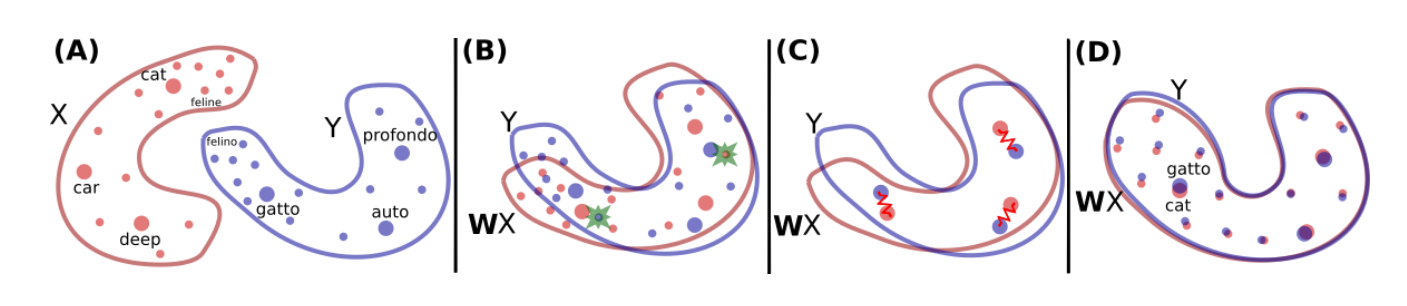


Lample, Guillaume, Alexis Conneau, Marc'Aurelio Ranzato, Ludovic Denoyer, and Hervé Jégou. "Word translation without parallel data." In International conference on learning representations. 2018.

---



## 7) RAG Example

Retrieval Augmented Generation (RAG) takes a database of pre-cached vector embeddings. During question answering, the question is embedded. Then the top-k most similar results to the question are retreived in order to add to the model as "context" during generation.


### Why RAG?
We want to add the context of all of our documents to the system. A naive approach would be to add all of our text to the beginning of the prompt so that the model can look over everything. However this raises several issues.


1.   Transformer models have quadratic time-space complexity.
2.   Lost-in-the-middle phenomenon.



We will combine this capability with a EuropePMC search API. We can search for all relevant articles, then ask the same questions about each article.



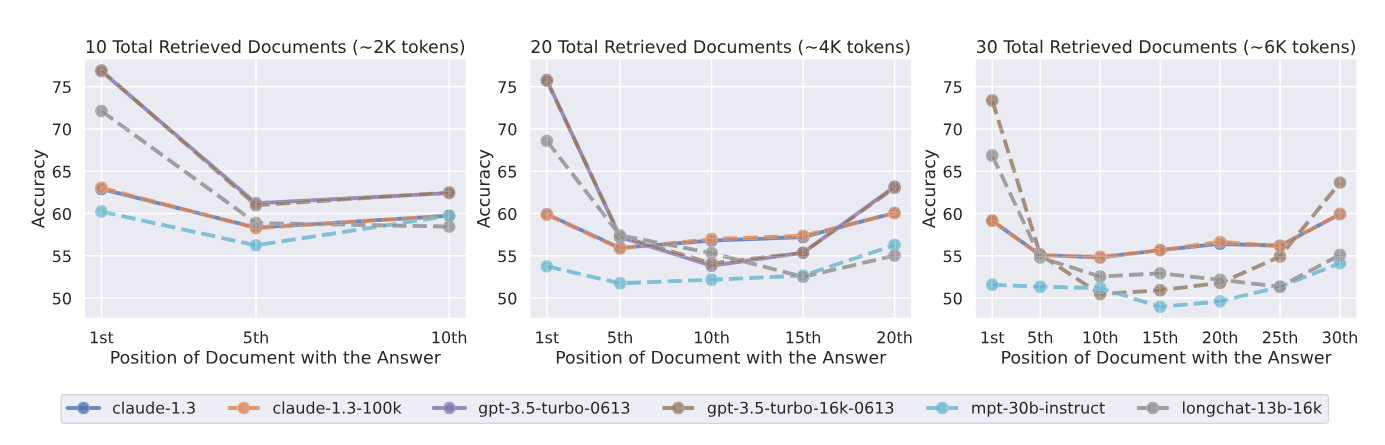


Nelson F. Liu, Kevin Lin, John Hewitt, Ashwin Paranjape, Michele Bevilacqua, Fabio Petroni, and Percy Liang. 2024. Lost in the Middle: How Language Models Use Long Contexts. Transactions of the Association for Computational Linguistics, 12:157–173.

Keles, Feyza Duman, Pruthuvi Mahesakya Wijewardena, and Chinmay Hegde. "On the computational complexity of self-attention." In International conference on algorithmic learning theory, pp. 597-619. PMLR, 2023.


In [ ]:

from langchain_huggingface import HuggingFacePipeline
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from transformers import BitsAndBytesConfig

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document


from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser, BaseOutputParser #, BooleanOutputParser
import re
import httpx



# this restricts the LLM output to yes or no (without additional text)
class YesNoOutput(BaseModel):
  answer: str = Field(description="The yes or no answer to the question")

class RobustYesNoParser(BaseOutputParser):
    """Custom parser that tries Pydantic first, then falls back to regex parsing"""


    def parse(self, text: str) -> YesNoOutput:
        # First, try the standard Pydantic parser
        try:
            pydantic_parser = PydanticOutputParser(pydantic_object=YesNoOutput)
            return pydantic_parser.parse(text)
        except Exception as e:
            # print(f"Pydantic parsing failed: {e}")
            # print(f"Raw output: {text}")


            # Fallback: Try to extract yes/no from the text
            return self._fallback_parse(text)

    def _fallback_parse(self, text: str) -> YesNoOutput:
        # Clean the text
        text_lower = text.lower().strip()

        # Method 1: Look for JSON-like structure that might be malformed
        json_match = re.search(r'\{[^}]*"answer"[^}]*:\s*"([^"]*)"[^}]*\}', text, re.IGNORECASE)
        if json_match:
            answer = json_match.group(1).strip()
            if answer.lower() in ['yes', 'no']:
                return YesNoOutput(answer=answer.lower())

        # Method 2: Look for "answer": "yes/no" pattern
        answer_match = re.search(r'"answer":\s*"(yes|no)"', text_lower)
        if answer_match:
            return YesNoOutput(answer=answer_match.group(1))

        # Method 3: Look for explicit yes or no at the beginning
        if text_lower.startswith('yes'):
            return YesNoOutput(answer="yes")
        elif text_lower.startswith('no'):
            return YesNoOutput(answer="no")

        if "yes" in text_lower:
          if "no" not in text_lower:
            return YesNoOutput(answer="yes")

        if "no" in text_lower:
          if "yes" not in text_lower:
            return YesNoOutput(answer="no")

        # print(text)

        raise

    def get_format_instructions(self) -> str:
        pydantic_parser = PydanticOutputParser(pydantic_object=YesNoOutput)
        return pydantic_parser.get_format_instructions()



# load an instruction-tuned model from huggingface
# speed up on GPU using quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",  # Use NF4 quantization
    bnb_4bit_compute_dtype=torch.float16,  # Compute dtype
    bnb_4bit_use_double_quant=True,  # Use double quantization for better accuracy
)
llm = HuggingFacePipeline.from_model_id(
    model_id="Qwen/Qwen3-0.6B",
    task="text-generation",
    device_map="auto",
    # pipeline_kwargs=default_kwargs,
    pipeline_kwargs={ "max_new_tokens": 512, "do_sample":False, "repetition_penalty": 1.1, "framework":"pt",}, # "token":HF_ACCESS_TOKEN}, #, "temperature": 0.0,
    model_kwargs={"quantization_config": quantization_config, "trust_remote_code": True, "cache_dir":None}, #, "token":HF_ACCESS_TOKEN},
)



# parser = PydanticOutputParser(pydantic_object=YesNoOutput)
parser = RobustYesNoParser()

prompt = PromptTemplate(
    template="""Answer the following question.\n\n{user_question}\n\n{format_instructions}""",
    input_variables=["user_question"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

# print(parser.get_format_instructions())

# Chain prompt -> LLM -> parser
chain = prompt | llm | parser

print("processing question")
result = chain.invoke({"user_question": "Is it cold on the moon?"})

print("Is it cold on the moon?")
print(result)






tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1afef32d-f6a0-4ecc-a8da-76665f2685fa)')' thrown while requesting HEAD https://huggingface.co/Qwen/Qwen3-0.6B/resolve/main/config.json
Retrying in 1s [Retry 1/5].


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`generation_config` default values have been modified to match model-specific defaults: {'do_sample': True}. If this is not desired, please set these values explicitly.


processing question
Is it cold on the moon?
answer='no'


In [ ]:
import httpx
import re
from bs4 import BeautifulSoup
import time

"""
documentation
https://europepmc.org/RestfulWebService#!/Europe32PMC32Articles32RESTful32API/searchPOST
"""


url = "https://www.ebi.ac.uk/europepmc/webservices/rest/searchPOST"

# Clean search string
search_string = 'BODY:"pollution" (LICENSE:"cc by" OR LICENSE:"cc-by" OR LICENSE:"cc by sa" OR LICENSE:"cc-by sa" OR LICENSE:"cc by-sa" OR LICENSE:"cc-by-sa")'

# Request data
data = {
    "query": search_string,
    "resultType": "idList",
    "sort_cited": "y",
    "format": "json"
}


# Send request
try:
    response = httpx.post(
        url,
        data=data,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        timeout=30.0
    )
    response.raise_for_status()

    results = response.json()
    print(f"Found {results.get('hitCount', 0)} articles")

    print(len(results["resultList"]["result"]))

    top_result = results["resultList"]["result"][0]

    if "idList" in results:
        print("First 5 PMC IDs:")
        for pmc_id in results["idList"][:5]:
            print(f"- {pmc_id}")

except httpx.RequestError as e:
    print(f"Request failed: {e}")
except Exception as e:
    print(f"Error: {e}")


for result in results["resultList"]["result"]:
  try:
    pmcid = result["pmcid"]
  except:
    continue
  print(pmcid)

  # now lets get the full text from the top result:
  try:
    response = httpx.get(
        url=f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/fullTextXML",
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        timeout=30.0,
    )
  except httpx.RequestError as e:
    print(f"Request failed: {e}")
  except Exception as e:
    print(f"Error: {e}")


  # Look through the xml content using beautiful soup

  soup = BeautifulSoup(response.content, 'xml')

  extracted = {
    'title': '',
    'abstract': '',
    'body': '',
    'full_text': ''
  }

  # Extract title
  title_elem = soup.find('article-title')
  if title_elem:
    extracted['title'] = title_elem.get_text().strip()

  # Extract abstract
  abstract_elem = soup.find('abstract')
  if abstract_elem:
    extracted['abstract'] = abstract_elem.get_text().strip()

  # Extract body text
  body_elem = soup.find('body')
  if body_elem:
    # Remove references, figures, tables, etc.
    for unwanted in body_elem.find_all(['xref', 'fig', 'table-wrap', 'ref-list']):
        unwanted.decompose()

    extracted['body'] = body_elem.get_text().strip()

  # Combine all text
  all_text_parts = [extracted['title'], extracted['abstract'], extracted['body']]
  extracted['full_text'] = '\n\n'.join(part for part in all_text_parts if part)

  # Clean up whitespace
  for key in extracted:
    extracted[key] = re.sub(r'\s+', ' ', extracted[key]).strip()

  if extracted["full_text"].strip()=="":
    continue

  print(extracted["full_text"])
  print("Whole article")
  print("\tWord count:", len(extracted["full_text"].split(" ")))
  print("\tExpected reading time:", int(len(extracted["full_text"].split(" "))/300) ,"min" )
  print("Abstract only")
  print("\tWord count:", len(extracted["abstract"].split(" ")))
  print("\tExpected reading time:", f'{len(extracted["abstract"].split(" "))/300:.2f} min' )


  text_doc = Document(
      page_content=extracted['full_text'],
      metadata={
          "source": "europe_pmc",
          "pmcid": pmcid,
          "title": extracted["title"],
      }
  )

  # start the AI timer
  start_time = time.time()
  # this is the class that will split the documents
  text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=50, add_start_index=True
    )
  #split the documents
  all_splits = text_splitter.split_documents([text_doc])


  # Create embeddings for documents and store them in a vector store
  vectorstore = SKLearnVectorStore.from_documents(
      documents=all_splits,
      embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
  )

  # make a retriever object that fetches the top 3 results for each study
  retriever = vectorstore.as_retriever(k=3)



  # Define the prompt template for the LLM
  prompt = PromptTemplate(
      template="""
      Documents: {documents}
      Answer the following question with no additional text.
      Question: {user_question}
      {format_instructions}
      """,
      input_variables=["user_question", "documents"],
      partial_variables={"format_instructions":parser.get_format_instructions()}
  )



  question = "Does this study involve human subjects?"

  # get the relevant embeddings that are related to the question:
  relevant_documents = retriever.invoke(question)
  # Extract content from retrieved documents
  # for doc in relevant_documents:
  #   print(doc)
  doc_texts = "\n".join([doc.page_content for doc in relevant_documents])


  #  prompt -> LLM -> parser
  chain = prompt | llm | parser


  print("processing question")
  try:
    result = chain.invoke({"user_question": question,"documents":doc_texts})
  except:
    continue
  print(question)
  print(result)
  print(f"AI time {(time.time()-start_time)/60:.2f} min")

  print("-"*25)








Found 54 articles
25
PMC12340727
SatHealth: A Multimodal Public Health Dataset with Satellite-based Environmental Factors Living environments play a vital role in the prevalence and progression of diseases, and understanding their impact on patient’s health status becomes increasingly crucial for developing AI models. However, due to the lack of long-term and fine-grained spatial and temporal data in public and population health studies, most existing studies fail to incorporate environmental data, limiting the models’ performance and real-world application. To address this shortage, we developed SatHealth, a novel dataset combining multimodal spatiotemporal data, including environmental data, satellite images, all-disease prevalences estimated from medical claims, and social determinants of health (SDoH) indicators. We conducted experiments under two use cases with SatHealth: regional public health modeling and personal disease risk prediction. Experimental results show that living en

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

processing question
Does this study involve human subjects?
answer='yes'
AI time 2.07 min
-------------------------
PMC12430804
Global, regional, and national burden of endometriosis among women of childbearing age from 1990 to 2021: a cross-sectional analysis from the 2021 global burden of disease study Background:Endometriosis is a major contributor to infertility and pelvic pain, which brings a significant burden on family and society. Although the data of endometriosis in Global Burden of Disease (GBD) 2019 was reviewed, no updated analysis has been conducted using GBD 2021, and the disease burden across different age groups has not been analyzed. The aim of this cross-sectional analysis was to provide an up-to-date assessment of the prevalence, incidence, and disability-adjusted life-years (DALYs) of endometriosis from 1990 to 2021 at the global, national, and regional levels.Material and methods:We obtained data on the prevalence, incidence, and DALYs of endometriosis from GBD 20